# 流程架構分為「模型設計端」與「應用端」，下列為應用端實例：


<img src="https://raw.githubusercontent.com/j82887/Face-Detection/master/00_Image/Flowchart%20%E2%80%93%20Facial%20Expression%20Recognition.png">



## 讀取Tensorflow中的Keras模型（.h5）

* 使用summary()來打印模型的架構

In [1]:
from tensorflow import keras
model = keras.models.load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 256)      

## 定義標籤的字典與顏色

## 建立detect_faces方法
* 輸入為影像，輸出為灰階影像與人臉的左上角座標與寬高

## 建立face_check方法
* 輸入為影像與表情辨識模型，輸出為人臉辨識的結果與繪製後的影像

In [2]:
# 定義標籤的字典與顏色
expression_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
colors = [(0,0,255),(0,0,0),(135,138,128),(18,153,255),(255,0,0),(240,32,160),(0,255,0)]
# 0:紅色, 1:黑色, 2:灰色, 3:橘色, 4:藍色, 5:紫色, 6:綠色
# 0:生氣, 1:厭惡, 2:恐懼, 3:開心, 4:難過, 5:驚訝, 6:中立

# 匯入人臉辨識器
import dlib
detector = dlib.get_frontal_face_detector()

# 建立detect_faces方法
def detect_faces(frame):
    
    # 使用OpenCV獲取人臉
    #face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    #faces = face_cascade.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=3,minSize=(15, 15),flags = cv2.CASCADE_SCALE_IMAGE)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 使用Dlib獲取人臉
    face = detector(frame)
    
    # 建立初始空的列表
    faces = []
    
    # 將畫面中的人臉依序存放左上角座標與寬高
    for i in range(len(face)):
        x = face[i].left()
        y = face[i].top()
        w = face[i].right()-face[i].left()
        h = face[i].bottom()-face[i].top()
        if x<0:
            x = 0
        if y<0:
            y = 0
        faces.append((x, y, w, h))
        
    return gray, faces

# 建立face_check方法
def face_check(img, model):
    
    frame = img
    
    # 代入detect_faces方法
    gray, faces = detect_faces(frame)
    
    # 建立只有key(faces)沒有元素得的空字典
    data = {"faces" : []}
    
    # 將每次的人臉左上角座標與寬高代入迴圈
    for i, (x, y, w, h) in enumerate(faces):
        
        # 透過座標與寬高得到灰階的人臉區域
        roi_gray = gray[y:y + h, x:x + w]
        
        # 陣列改變大小，並且內外增加維度，使可以帶入模型的輸入形式
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        
        # 像素進行正規化
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        
        # 將輸入代入模型進行預測
        prediction = model.predict(cropped_img)[0]
        
        # 轉為列表
        pred_array = prediction.tolist()
        
        # 建立字典，將單張人臉的預測結果以浮點數方式儲存
        predictions = {
            "angry": float(prediction[0]),
            "disgusted": float(prediction[1]),
            "fearful": float(prediction[2]),
            "happy": float(prediction[3]),
            "sad": float(prediction[4]),
            "surprised": float(prediction[5]),
            "neutral": float(prediction[6])
        }
        
        # 將（數張）人臉儲存至data的字典之key的faces中
        data["faces"].append({"id" : i,"xywh": (x, y, w, h),"predictions": predictions})
        
        # 繪製矩形
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 4)
        
        # 繪製文字
        cv2.putText(frame,"{}: {}".format(max(predictions, key=predictions.get),round(predictions[max(predictions, key=predictions.get)],3)),(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,colors[pred_array.index(max(pred_array))],2)
        
        # 繪製圖像
        frame = face_post(frame, (x, y), w, max(predictions, key=predictions.get))
        
    return data, frame

## 建立face_post方法
* 輸入為整張影像畫面、人臉左上角座標、人臉的寬與表情預測名稱
* 輸出為該表情貼圖後的整張影像畫面

1. 條件式：以表情預測名稱來讀取貼圖
2. 貼圖的寬高更改為人臉寬之一半
3. 計算預貼上之貼圖的左上角與右下角座標
4. 以條件式定義左上角不能超出畫面外
5. 貼圖處理：
        a. 灰階化
        b. 二值化
        c. 取出預貼圖之區域
        d. 區域與貼圖透過遮罩生成final以貼圖之區域影像
        e. 整張影像更換預貼圖之區域
    
<img src="https://raw.githubusercontent.com/j82887/Face-Detection/master/00_Image/Total_Second.png" width="600">


In [3]:
def face_post(frame, top_left, width, prediction):
    
    if prediction =="angry":
        img = cv2.imread("Image_fer/00_Angry_Second.png")
    if prediction =="disgusted":
        img = cv2.imread("Image_fer/01_Disgust_Second.png")
    if prediction =="fearful":
        img = cv2.imread("Image_fer/02_Fear_Second.png")
    if prediction =="happy":
        img = cv2.imread("Image_fer/03_Happy_Second.png")
    if prediction =="sad":
        img = cv2.imread("Image_fer/04_Sad_Second.png")
    if prediction =="surprised":
        img = cv2.imread("Image_fer/05_Surprise_Second.png")
    if prediction =="neutral":
        img = cv2.imread("Image_fer/06_Neutral_Second.png")
    
    img_wh = int(width/2)
    img = cv2.resize(img, (img_wh,img_wh))
        
    # 計算左上角與右下角
    img_top_left = (int(top_left[0]-img_wh),int(top_left[1]))
    img_bottom_right = (int(top_left[0]),int(top_left[1]+img_wh))
    
    if img_top_left[0]>0 and img_top_left[1]>0:
    
        # 轉為灰階
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 二值化
        _, mask = cv2.threshold(img_gray, 25, 255, cv2.THRESH_BINARY_INV)
    
        area = frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh]
        area_no = cv2.bitwise_and(area,area,mask=mask)
        final = cv2.add(area_no, img)
        frame[img_top_left[1]: img_top_left[1]+img_wh, img_top_left[0]: img_top_left[0]+img_wh] = final

    return frame

## 影像進行測試
* 讀取影像
* 測試face_check方法
* 使用matplotlib繪出結果

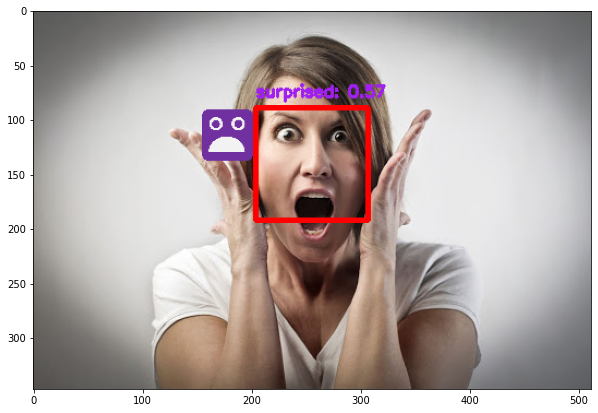

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("Image_test/unnamed.jpg")
data, frame = face_check(img, model)

frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(frame)
plt.show()

## 攝像頭進行測試
* 讀取攝像頭影像
* 測試face_check方法

In [5]:
import cv2

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, img = VIDEO_IN.read()
    img = cv2.resize(img, None, fx=0.3, fy=0.3)
    data, img = face_check(img, model)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()

## Keras模型轉換成Tensorflow lite for Android

In [5]:
import tensorflow as tf

model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/rx/hz8p36g50j19grn7rfdkt4kr0000gn/T/tmpqfk66hf9/assets


INFO:tensorflow:Assets written to: /var/folders/rx/hz8p36g50j19grn7rfdkt4kr0000gn/T/tmpqfk66hf9/assets


94381872